This notebook produces the figures to demonstrate our four SNe distribution models.

Model 1: SNe are randomly placed within the galaxy map (PHANGS--ALMA footprint).  
Model 2: SNe follow the gas distribution within the galaxy (PHANGS--ALMA).  
Model 3: SNe follow the stellar profile of the galaxy (IRAC/WISE infrared 3.6 microns).  
Model 4: SNe are split between Models 2 & 3 with ~70% CCSNe following the gas distribution and the reminaing following the stellar profile.  

In [14]:
#import packages and initialize settings
import os
import numpy as np
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.io import ascii
from reproject import reproject_interp

plt.rc('text',usetex=True)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']="white"

import sys
sys.path.append('/home/mayker.1/Desktop/PythonFunctions')
from deprojectGalaxy import deproject
from FindNearestMC import int2mass, mass2int, findNearest, angDistToPc
from normalize import norm

In [15]:
database = Table.read('../Data/3.SNe+GalData.csv', format = "csv")


In [16]:
def runModels(galaxy, image, centerCoord, pa, incl, galDist, modelType = 1):
#convert pixel map to x' and y'
    
    if os.path.isfile(image):

        # read in fits files
        hdu_int  = pyfits.open(image)
        intMap      = hdu_int[0].data

        #Convert x & y pixels to ra and dec
        wcs      = WCS(hdu_int[0].header, naxis=2)
        naxis    = wcs._naxis # size of image naxis[0] = x and [1] = y
        grid     = np.indices((naxis[1],naxis[0]))
        ra, dec  = wcs.wcs_pix2world(grid[1],grid[0],0)

        #deproject ra and dec to dx and dy
        radius, projang, dx, dy = deproject(center_coord=centerCoord, incl=incl, pa=pa, ra=ra, dec=dec,return_offset=True)

        #flatten data structures 
        f_int  = intMap.flatten()
        f_ra   = ra.flatten()
        f_dec  = dec.flatten()    
        f_dx   = dx.flatten()
        f_dy   = dy.flatten()

        #remove nans
        keep  = np.where(np.isfinite(f_int))
        ra    = f_ra[keep]
        dec   = f_dec[keep]
        inten = f_int[keep]
        dx    = f_dx[keep]
        dy    = f_dy[keep]
        
        for j in range(100):

            #if model is random
            if modelType == 1:
                numrowsX = len(dx)    
                numrowsY = len(dy)  

                randIntX = np.random.randint(low=0, high=numrowsX)
                randIntY = np.random.randint(low=0, high=numrowsY)

            #if model is gas density weighted
            else:
                intArr = np.clip(inten, a_min=0.0, a_max=None)
                total = sum(intArr)
                prob  = intArr/total 
                prob  = norm(prob)
                nX = len(dx)
                nY = len(dy)
                indiciesX = np.arange(nX, dtype=int)
                randIntX = np.random.choice(indiciesX, p=prob)
                indiciesY = np.arange(nY, dtype=int)
                randIntY = np.random.choice(indiciesY, p=prob)


            rX   = dx[randIntX]
            rY   = dy[randIntY]

        logmap = np.log10(intMap)
        plt.figure(figsize = (4,4))
        plt.imshow(logmap, cmap='viridis')
        plt.colorbar()


<ipython-input-16-eada40c6faa7>:61: RuntimeWarning: divide by zero encountered in log10
  logmap = np.log10(intMap)
<ipython-input-16-eada40c6faa7>:61: RuntimeWarning: invalid value encountered in log10
  logmap = np.log10(intMap)


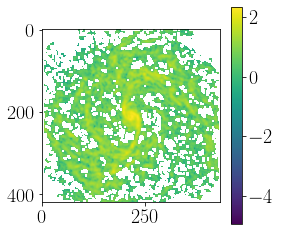

In [17]:

centerCoords = [(database["orient_ra"][i], database["orient_dec"][i]) for i in range(len(database))]    

i = 35
runModels(database["galaxy"][i],database["ImageFile150"][i],centerCoords[i],database["orient_posang"][i],database["orient_incl"][i],database["dist"][i])

# need to print SNe!

In [ ]:
runModels("ngc4303", modelType = 2)
